# Surviving the Titanic with Random Forests

## Setup

In [1]:
%matplotlib inline

In [2]:
# The model to use 
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd

# Import the data
X = pd.read_csv("train.csv")
y = X.pop("Survived")

In [3]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I know that there are categorical variables in the dataset, but I will skip them for the moment. I will impute age though, because it will be fast.

In [4]:
# Impute Age with mean
X["Age"].fillna(X.Age.mean(), inplace=True)

# Confirm the code is correct
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [6]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [7]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, but I mention this 
# for awareness. By the way, attributes in sklearn that have a trailing underscore are only available after the model has been fit.
model.oob_score_

0.1361695005913669

In [8]:
y_oob = model.oob_prediction_
print("c-stat: ", roc_auc_score(y, y_oob))

c-stat:  0.73995515504


We now have a benchmark. This isn't very good for this dataset; however, it provides us a benchmark for improvement. Before changing parameters for the Random Forest, let's whip this dataset into shape.

In [9]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [10]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Garside, Miss. Ethel",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [11]:
# Drop the variables I don't feel like dealing with for this tutorial
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [12]:
# Change the Cabin variable to be only the first letter or None
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Cabin"] = X.Cabin.apply(clean_cabin)

In [13]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [14]:
# In a previous assignment, I noticed Parch was not a useful variable. 
X.drop(['Parch'], axis=1, inplace=True)

In [15]:
X

,Pclass,Age,SibSp,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5,3,29.699118,0,8.4583,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
6,1,54.000000,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,3,2.000000,3,21.0750,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
8,3,27.000000,0,11.1333,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,2,14.000000,1,30.0708,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [16]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [17]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print ("C-stat: ", roc_auc_score(y, model.oob_prediction_))

C-stat:  0.865787343282


This is a pretty good model. Now, before we try some different parameters for the model, let's use the Random Forest to help us with some EDA.

### Variable importance measures

In [18]:
model.feature_importances_

array([  9.12074602e-02,   2.46984034e-01,   4.73847172e-02,
         2.23899970e-01,   1.55781139e-01,   1.47375082e-01,
         2.84323202e-03,   3.53404020e-03,   5.91966977e-03,
         4.16794234e-03,   8.73328868e-03,   9.57042886e-04,
         7.14562953e-04,   2.70678793e-02,   1.48321454e-04,
         1.06803132e-02,   0.00000000e+00,   6.07022450e-03,
         1.65310800e-02])

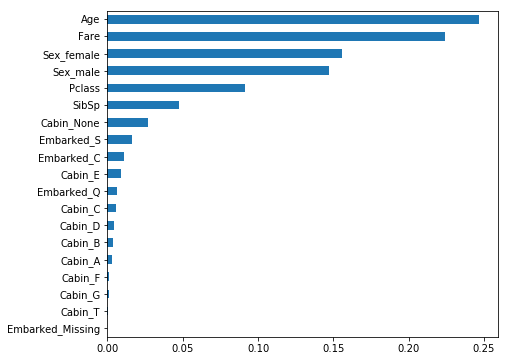

In [19]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6));

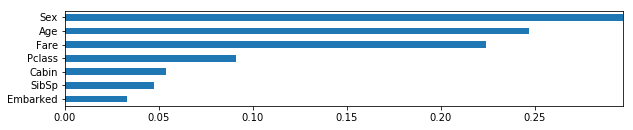

In [20]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict)
    results.sort_values(inplace=True)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

## Parameter tests

Parameters to test

 * ### Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
 * ### Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

### n_jobs

In [21]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 2.27 s per loop


In [22]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 1.51 s per loop


### n_estimators

30 trees
C-stat:  0.858618540888

50 trees
C-stat:  0.864948497534

100 trees
C-stat:  0.865787343282

200 trees
C-stat:  0.866122881582

500 trees
C-stat:  0.866261357705

1000 trees
C-stat:  0.866626189031

1500 trees
C-stat:  0.865688812194

2000 trees
C-stat:  0.865867233354



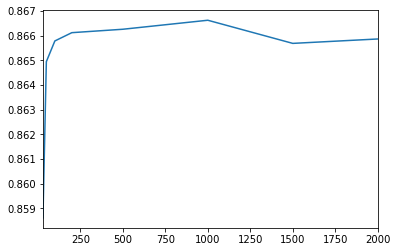

In [23]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 1500, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42)
    model.fit(X, y)
    print (trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.866626189031

None option
C-stat:  0.866626189031

sqrt option
C-stat:  0.867126833477

log2 option
C-stat:  0.867126833477

0.1 option
C-stat:  0.864328017981

0.2 option
C-stat:  0.867294602627

0.3 option
C-stat:  0.868950990104

0.4 option
C-stat:  0.868013613268

0.5 option
C-stat:  0.868599473791

0.6 option
C-stat:  0.867664759957

0.7 option
C-stat:  0.866708742104

0.8 option
C-stat:  0.868069536318

0.9 option
C-stat:  0.866873848251



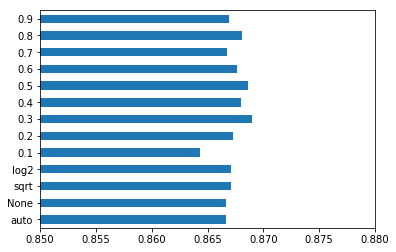

In [24]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features=max_features)
    model.fit(X, y)
    print (max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

In [25]:
print(max(results))

0.868950990104


### min_samples_leaf

1 min samples
C-stat:  0.867294602627

2 min samples
C-stat:  0.874945408451

3 min samples
C-stat:  0.872223820024

4 min samples
C-stat:  0.87154741742

5 min samples
C-stat:  0.868815176983

6 min samples
C-stat:  0.865411859947

7 min samples
C-stat:  0.862759509581

8 min samples
C-stat:  0.862312125182

9 min samples
C-stat:  0.858152515472

10 min samples
C-stat:  0.857843607196



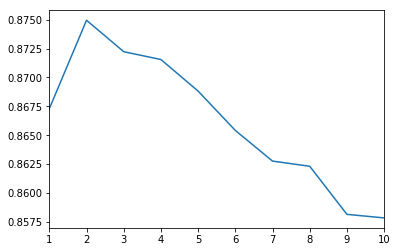

In [26]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features=0.2, 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print (min_samples, "min samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot();

###  max_leaf_nodes

10 max leaf
C-stat:  0.8560540696

25 max leaf
C-stat:  0.861326814304

50 max leaf
C-stat:  0.867957690218

75 max leaf
C-stat:  0.87327304296

100 max leaf
C-stat:  0.875035950532

125 max leaf
C-stat:  0.874790954314

150 max leaf
C-stat:  0.87486551838

175 max leaf
C-stat:  0.87486551838

200 max leaf
C-stat:  0.87486551838



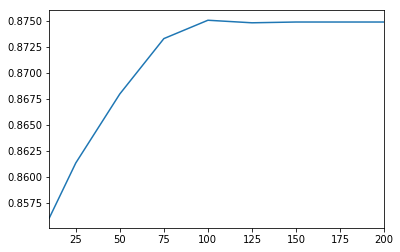

In [27]:
# Testing max_leaf_nodes. 

results = []
maximum_leaf_nodes = [10, 25, 50, 75, 100, 125, 150, 175, 200]

for max_leaf in maximum_leaf_nodes:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features=0.2, 
                                  max_leaf_nodes=max_leaf,
                                  min_samples_leaf=2)
    model.fit(X, y)
    print (max_leaf, "max leaf")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, maximum_leaf_nodes).plot();

## Best Model Thus Far

In [28]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features=0.2,
                              max_leaf_nodes = 100,
                              min_samples_leaf=2)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

C-stat:  0.875035950532


# 0.875 > 0.874

# Brute Force Loops to Find the Best Parameters

In [29]:
# I noticed that the results would change depending on the different combinations of the parameter values.
# So I decided to test everything to find the best settings. This is probably overkill, but I like being certain.
# It took a long time to run the four loop so I might need to develop a faster more strategic way to do this.

## Best Model

In [32]:
# I placed the results before the big four loop. However, please note that I ran the code below before this code

model = RandomForestRegressor(oob_score=True,
                              n_jobs=-1,
                              random_state=42,
                              n_estimators = 50,
                              max_features=0.6,
                              min_samples_leaf=3,
                              max_leaf_nodes=100)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

C-stat:  0.878758827853


In [30]:
best_results = .7
best_parameters = ''

n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]
max_features_options = ["auto", None, "sqrt", "log2", 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
maximum_leaf_nodes = [10, 50, 100, 150, 200]

for n_estimator in n_estimator_options:
    for max_feature in max_features_options:
        for min_sample_leaf in min_samples_leaf_options:
            for max_leaf in maximum_leaf_nodes:
                model = RandomForestRegressor(oob_score=True,
                                              n_jobs=-1,
                                              random_state=42,
                                              n_estimators = n_estimator,
                                              max_features=max_feature,
                                              min_samples_leaf=min_sample_leaf,
                                              max_leaf_nodes=max_leaf)
                model.fit(X,y)
                roc = roc_auc_score(y, model.oob_prediction_)
                if roc > best_results:
                    best_results = roc
                    best_parameters = 'n_estimator: ' + str(n_estimator) + ', ' + 'max_feature: ' + str(max_feature) + ', ' + 'min_sample_leaf: ' + str(min_sample_leaf) + ', ' + 'max_leaf: ' + str(max_leaf)
                print('Parameter => ' + 'n_estimator: ' + str(n_estimator) + ', ' + 'max_feature: ' + str(max_feature) + ', ' + 'min_sample_leaf: ' + str(min_sample_leaf) + ', ' + 'max_leaf: ' + str(max_leaf))
                print('AUC: ' + str(roc))
print('best parameters:', best_parameters)
print('best results:', best_results)

Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 1, max_leaf: 10
AUC: 0.848081040488
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 1, max_leaf: 50
AUC: 0.854903652574
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 1, max_leaf: 100
AUC: 0.85910320732
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 1, max_leaf: 150
AUC: 0.854759850446
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 1, max_leaf: 200
AUC: 0.854879685553
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 2, max_leaf: 10
AUC: 0.84526890998
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 2, max_leaf: 50
AUC: 0.860464001534
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 2, max_leaf: 100
AUC: 0.867417100736
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 2, max_leaf: 150
AUC: 0.868761916936
Parameter => n_estimator: 30, max_feature: auto, min_sample_leaf: 2, max_leaf: 

Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 7, max_leaf: 10
AUC: 0.851463053505
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 7, max_leaf: 50
AUC: 0.867680737971
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 7, max_leaf: 100
AUC: 0.867664759957
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 7, max_leaf: 150
AUC: 0.867664759957
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 7, max_leaf: 200
AUC: 0.867664759957
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 8, max_leaf: 10
AUC: 0.849891882104
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 8, max_leaf: 50
AUC: 0.860988613002
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 8, max_leaf: 100
AUC: 0.860988613002
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 8, max_leaf: 150
AUC: 0.860988613002
Parameter => n_estimator: 30, max_feature: None, min_sample_leaf: 8, max_leaf

Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 3, max_leaf: 10
AUC: 0.858626529895
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 3, max_leaf: 50
AUC: 0.865960438437
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 3, max_leaf: 100
AUC: 0.868724634902
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 3, max_leaf: 150
AUC: 0.868639418826
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 3, max_leaf: 200
AUC: 0.868639418826
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 4, max_leaf: 10
AUC: 0.858456097743
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 4, max_leaf: 50
AUC: 0.865816636308
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 4, max_leaf: 100
AUC: 0.865907178389
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 4, max_leaf: 150
AUC: 0.865907178389
Parameter => n_estimator: 30, max_feature: log2, min_sample_leaf: 4, max_leaf

Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 100
AUC: 0.844427401229
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 150
AUC: 0.844427401229
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 200
AUC: 0.844427401229
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 10
AUC: 0.835591559348
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 50
AUC: 0.838126737609
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 100
AUC: 0.838126737609
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 150
AUC: 0.838126737609
Parameter => n_estimator: 30, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 200
AUC: 0.838126737609
Parameter => n_estimator: 30, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 10
AUC: 0.855606685201
Parameter => n_estimator: 30, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 50

Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 5, max_leaf: 200
AUC: 0.867185419529
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 10
AUC: 0.858727723985
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 50
AUC: 0.864841977439
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 100
AUC: 0.864916541506
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 150
AUC: 0.864916541506
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 200
AUC: 0.864916541506
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 10
AUC: 0.859233694436
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 50
AUC: 0.866642167045
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 100
AUC: 0.866642167045
Parameter => n_estimator: 30, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 150
AUC:

Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 50
AUC: 0.871238509145
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 100
AUC: 0.872543380309
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 150
AUC: 0.871680567539
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 200
AUC: 0.871680567539
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 10
AUC: 0.861662352603
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 50
AUC: 0.873198478893
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 100
AUC: 0.870988186921
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 150
AUC: 0.870988186921
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 200
AUC: 0.870988186921
Parameter => n_estimator: 30, max_feature: 0.5, min_sample_leaf: 4, max_leaf: 10
AUC:

Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 150
AUC: 0.864908552498
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 200
AUC: 0.864908552498
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 10
AUC: 0.851170123244
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 50
AUC: 0.865763376261
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 100
AUC: 0.865763376261
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 150
AUC: 0.865763376261
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 200
AUC: 0.865763376261
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 10
AUC: 0.850562958702
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 50
AUC: 0.865955112432
Parameter => n_estimator: 30, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 100
A

Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 10
AUC: 0.855452231063
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 50
AUC: 0.870977534912
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 100
AUC: 0.871014816945
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 150
AUC: 0.871014816945
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 200
AUC: 0.871014816945
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 10
AUC: 0.852341844289
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 50
AUC: 0.87021325323
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 100
AUC: 0.869914996964
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 150
AUC: 0.869914996964
Parameter => n_estimator: 30, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 200
AUC: 

Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 1, max_leaf: 100
AUC: 0.866863196242
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 1, max_leaf: 150
AUC: 0.861933978845
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 1, max_leaf: 200
AUC: 0.861936641847
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 2, max_leaf: 10
AUC: 0.841269080412
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 2, max_leaf: 50
AUC: 0.863047113838
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 2, max_leaf: 100
AUC: 0.868982946133
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 2, max_leaf: 150
AUC: 0.870096081126
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 2, max_leaf: 200
AUC: 0.870096081126
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 3, max_leaf: 10
AUC: 0.843905452764
Parameter => n_estimator: 50, max_feature: auto, min_sample_leaf: 3, max_lea

Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 7, max_leaf: 100
AUC: 0.868319858541
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 7, max_leaf: 150
AUC: 0.868319858541
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 7, max_leaf: 200
AUC: 0.868319858541
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 8, max_leaf: 10
AUC: 0.849556343804
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 8, max_leaf: 50
AUC: 0.865550336071
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 8, max_leaf: 100
AUC: 0.865550336071
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 8, max_leaf: 150
AUC: 0.865550336071
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 8, max_leaf: 200
AUC: 0.865550336071
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 9, max_leaf: 10
AUC: 0.849108959405
Parameter => n_estimator: 50, max_feature: None, min_sample_leaf: 9, max_lea

Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 3, max_leaf: 100
AUC: 0.872122625933
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 3, max_leaf: 150
AUC: 0.872122625933
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 3, max_leaf: 200
AUC: 0.872122625933
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 4, max_leaf: 10
AUC: 0.860581173638
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 4, max_leaf: 50
AUC: 0.868197360432
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 4, max_leaf: 100
AUC: 0.868085514332
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 4, max_leaf: 150
AUC: 0.868085514332
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 4, max_leaf: 200
AUC: 0.868085514332
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 5, max_leaf: 10
AUC: 0.862626359463
Parameter => n_estimator: 50, max_feature: log2, min_sample_leaf: 5, max_lea

Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 200
AUC: 0.844997283738
Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 10
AUC: 0.835303955091
Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 50
AUC: 0.838084129571
Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 100
AUC: 0.838084129571
Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 150
AUC: 0.838084129571
Parameter => n_estimator: 50, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 200
AUC: 0.838084129571
Parameter => n_estimator: 50, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 10
AUC: 0.855042128698
Parameter => n_estimator: 50, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 50
AUC: 0.867542261848
Parameter => n_estimator: 50, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 100
AUC: 0.867004335368
Parameter => n_estimator: 50, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 150

Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 50
AUC: 0.866242716689
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 100
AUC: 0.866599559007
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 150
AUC: 0.866599559007
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 200
AUC: 0.866599559007
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 10
AUC: 0.858647833914
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 50
AUC: 0.869347777458
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 100
AUC: 0.869347777458
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 150
AUC: 0.869347777458
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 200
AUC: 0.869347777458
Parameter => n_estimator: 50, max_feature: 0.3, min_sample_leaf: 8, max_leaf: 10
AUC:

Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 150
AUC: 0.873981401591
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 200
AUC: 0.873981401591
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 10
AUC: 0.858317621619
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 50
AUC: 0.874972038475
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 100
AUC: 0.877067821344
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 150
AUC: 0.877067821344
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 200
AUC: 0.877067821344
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 4, max_leaf: 10
AUC: 0.858322947624
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 4, max_leaf: 50
AUC: 0.871211879121
Parameter => n_estimator: 50, max_feature: 0.5, min_sample_leaf: 4, max_leaf: 100
AUC:

Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 10
AUC: 0.84890124522
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 50
AUC: 0.865843266332
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 100
AUC: 0.865843266332
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 150
AUC: 0.865843266332
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 200
AUC: 0.865843266332
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 10
AUC: 0.848139626541
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 50
AUC: 0.866785969173
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 100
AUC: 0.866785969173
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 150
AUC: 0.866785969173
Parameter => n_estimator: 50, max_feature: 0.6, min_sample_leaf: 10, max_leaf: 200


Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 100
AUC: 0.875507301953
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 150
AUC: 0.875507301953
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 200
AUC: 0.875507301953
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 10
AUC: 0.846967905495
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 50
AUC: 0.874940082447
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 100
AUC: 0.874817584337
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 150
AUC: 0.874817584337
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 6, max_leaf: 200
AUC: 0.874817584337
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 7, max_leaf: 10
AUC: 0.8494391717
Parameter => n_estimator: 50, max_feature: 0.8, min_sample_leaf: 7, max_leaf: 50
AUC: 0

AUC: 0.863571725306
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 1, max_leaf: 200
AUC: 0.863933893629
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 2, max_leaf: 10
AUC: 0.840518113742
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 2, max_leaf: 50
AUC: 0.870604714579
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 2, max_leaf: 100
AUC: 0.871656600518
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 2, max_leaf: 150
AUC: 0.871912248746
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 2, max_leaf: 200
AUC: 0.871912248746
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 3, max_leaf: 10
AUC: 0.842632537628
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 3, max_leaf: 50
AUC: 0.869038869183
Parameter => n_estimator: 100, max_feature: auto, min_sample_leaf: 3, max_leaf: 100
AUC: 0.872804354541
Parameter => n_estimator: 100, max_feature: auto

AUC: 0.871757794608
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 7, max_leaf: 150
AUC: 0.871757794608
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 7, max_leaf: 200
AUC: 0.871757794608
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 8, max_leaf: 10
AUC: 0.847617678075
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 8, max_leaf: 50
AUC: 0.869582121667
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 8, max_leaf: 100
AUC: 0.869582121667
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 8, max_leaf: 150
AUC: 0.869582121667
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 8, max_leaf: 200
AUC: 0.869582121667
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 9, max_leaf: 10
AUC: 0.848192886588
Parameter => n_estimator: 100, max_feature: None, min_sample_leaf: 9, max_leaf: 50
AUC: 0.867638129933
Parameter => n_estimator: 100, max_feature: None

Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 3, max_leaf: 100
AUC: 0.873944119558
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 3, max_leaf: 150
AUC: 0.873890859511
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 3, max_leaf: 200
AUC: 0.873890859511
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 4, max_leaf: 10
AUC: 0.858807614056
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 4, max_leaf: 50
AUC: 0.867776606057
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 4, max_leaf: 100
AUC: 0.86931582143
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 4, max_leaf: 150
AUC: 0.86931582143
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 4, max_leaf: 200
AUC: 0.86931582143
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 5, max_leaf: 10
AUC: 0.860245635339
Parameter => n_estimator: 100, max_feature: log2, min_sample_leaf: 5, 

AUC: 0.850365896526
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 150
AUC: 0.850365896526
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 200
AUC: 0.850365896526
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 10
AUC: 0.839202590569
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 50
AUC: 0.842909489875
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 100
AUC: 0.842909489875
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 150
AUC: 0.842909489875
Parameter => n_estimator: 100, max_feature: 0.1, min_sample_leaf: 10, max_leaf: 200
AUC: 0.842909489875
Parameter => n_estimator: 100, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 10
AUC: 0.856394933904
Parameter => n_estimator: 100, max_feature: 0.2, min_sample_leaf: 1, max_leaf: 50
AUC: 0.868729960907
Parameter => n_estimator: 100, max_feature: 0.2, min

AUC: 0.872122625933
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 5, max_leaf: 200
AUC: 0.872122625933
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 10
AUC: 0.857811651168
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 50
AUC: 0.866812599197
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 100
AUC: 0.866892489268
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 150
AUC: 0.866892489268
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 6, max_leaf: 200
AUC: 0.866892489268
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 10
AUC: 0.857193834617
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 50
AUC: 0.869454297553
Parameter => n_estimator: 100, max_feature: 0.3, min_sample_leaf: 7, max_leaf: 100
AUC: 0.869464949563
Parameter => n_estimator: 100, max_feature: 0.3, min_samp

AUC: 0.865284035833
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 1, max_leaf: 200
AUC: 0.862794128612
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 10
AUC: 0.854195293942
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 50
AUC: 0.87038102238
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 100
AUC: 0.872799028537
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 150
AUC: 0.872846962579
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 2, max_leaf: 200
AUC: 0.872846962579
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 10
AUC: 0.856645256128
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 50
AUC: 0.870247872261
Parameter => n_estimator: 100, max_feature: 0.5, min_sample_leaf: 3, max_leaf: 100
AUC: 0.873315650998
Parameter => n_estimator: 100, max_feature: 0.5, min_sampl

Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 7, max_leaf: 200
AUC: 0.871014816945
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 10
AUC: 0.854216597961
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 50
AUC: 0.867851170123
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 100
AUC: 0.867851170123
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 150
AUC: 0.867851170123
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 8, max_leaf: 200
AUC: 0.867851170123
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 10
AUC: 0.85091980102
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 50
AUC: 0.868974957126
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 9, max_leaf: 100
AUC: 0.868974957126
Parameter => n_estimator: 100, max_feature: 0.6, min_sample_leaf: 9, max_leaf:

AUC: 0.875707027131
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 3, max_leaf: 200
AUC: 0.875707027131
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 4, max_leaf: 10
AUC: 0.851622833648
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 4, max_leaf: 50
AUC: 0.873672493316
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 4, max_leaf: 100
AUC: 0.875456704907
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 4, max_leaf: 150
AUC: 0.875456704907
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 4, max_leaf: 200
AUC: 0.875456704907
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 10
AUC: 0.847505831975
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 50
AUC: 0.875840177249
Parameter => n_estimator: 100, max_feature: 0.8, min_sample_leaf: 5, max_leaf: 100
AUC: 0.876495275834
Parameter => n_estimator: 100, max_feature: 0.8, min_samp

AUC: 0.867068247425
Parameter => n_estimator: 100, max_feature: 0.9, min_sample_leaf: 10, max_leaf: 10
AUC: 0.84783604427
Parameter => n_estimator: 100, max_feature: 0.9, min_sample_leaf: 10, max_leaf: 50
AUC: 0.867126833477
Parameter => n_estimator: 100, max_feature: 0.9, min_sample_leaf: 10, max_leaf: 100
AUC: 0.867126833477
Parameter => n_estimator: 100, max_feature: 0.9, min_sample_leaf: 10, max_leaf: 150
AUC: 0.867126833477
Parameter => n_estimator: 100, max_feature: 0.9, min_sample_leaf: 10, max_leaf: 200
AUC: 0.867126833477
Parameter => n_estimator: 200, max_feature: auto, min_sample_leaf: 1, max_leaf: 10
AUC: 0.838398363851
Parameter => n_estimator: 200, max_feature: auto, min_sample_leaf: 1, max_leaf: 50
AUC: 0.863196241971
Parameter => n_estimator: 200, max_feature: auto, min_sample_leaf: 1, max_leaf: 100
AUC: 0.868101492347
Parameter => n_estimator: 200, max_feature: auto, min_sample_leaf: 1, max_leaf: 150
AUC: 0.864887248479
Parameter => n_estimator: 200, max_feature: auto,

Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 5, max_leaf: 200
AUC: 0.872479468252
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 6, max_leaf: 10
AUC: 0.841109300269
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 6, max_leaf: 50
AUC: 0.872538054304
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 6, max_leaf: 100
AUC: 0.872833647568
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 6, max_leaf: 150
AUC: 0.872833647568
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 6, max_leaf: 200
AUC: 0.872833647568
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 7, max_leaf: 10
AUC: 0.841008106179
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 7, max_leaf: 50
AUC: 0.871238509145
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 7, max_leaf: 100
AUC: 0.871286443188
Parameter => n_estimator: 200, max_feature: None, min_sample_leaf: 7

Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 1, max_leaf: 200
AUC: 0.867670085962
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 2, max_leaf: 10
AUC: 0.856075373619
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 2, max_leaf: 50
AUC: 0.869747227815
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 2, max_leaf: 100
AUC: 0.874492698047
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 2, max_leaf: 150
AUC: 0.874434111995
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 2, max_leaf: 200
AUC: 0.874434111995
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 3, max_leaf: 10
AUC: 0.856011461562
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 3, max_leaf: 50
AUC: 0.870114722142
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 3, max_leaf: 100
AUC: 0.873917489534
Parameter => n_estimator: 200, max_feature: log2, min_sample_leaf: 3

Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 7, max_leaf: 200
AUC: 0.857374918778
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 8, max_leaf: 10
AUC: 0.847303443795
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 8, max_leaf: 50
AUC: 0.854376378104
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 8, max_leaf: 100
AUC: 0.854376378104
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 8, max_leaf: 150
AUC: 0.854376378104
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 8, max_leaf: 200
AUC: 0.854376378104
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 10
AUC: 0.845556514236
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 50
AUC: 0.849705471937
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 9, max_leaf: 100
AUC: 0.849705471937
Parameter => n_estimator: 200, max_feature: 0.1, min_sample_leaf: 9, max_leaf

Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 3, max_leaf: 200
AUC: 0.871217205126
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 4, max_leaf: 10
AUC: 0.85637895589
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 4, max_leaf: 50
AUC: 0.868751264926
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 4, max_leaf: 100
AUC: 0.871137315054
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 4, max_leaf: 150
AUC: 0.871137315054
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 4, max_leaf: 200
AUC: 0.871137315054
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 5, max_leaf: 10
AUC: 0.856607974094
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 5, max_leaf: 50
AUC: 0.869512883605
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 5, max_leaf: 100
AUC: 0.870109396138
Parameter => n_estimator: 200, max_feature: 0.3, min_sample_leaf: 5, max_leaf:

Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 9, max_leaf: 200
AUC: 0.864431875073
Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 10, max_leaf: 10
AUC: 0.851106211187
Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 10, max_leaf: 50
AUC: 0.862775487596
Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 10, max_leaf: 100
AUC: 0.862775487596
Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 10, max_leaf: 150
AUC: 0.862775487596
Parameter => n_estimator: 200, max_feature: 0.4, min_sample_leaf: 10, max_leaf: 200
AUC: 0.862775487596
Parameter => n_estimator: 200, max_feature: 0.5, min_sample_leaf: 1, max_leaf: 10
AUC: 0.850893170997
Parameter => n_estimator: 200, max_feature: 0.5, min_sample_leaf: 1, max_leaf: 50
AUC: 0.866620863026
Parameter => n_estimator: 200, max_feature: 0.5, min_sample_leaf: 1, max_leaf: 100
AUC: 0.868373118589
Parameter => n_estimator: 200, max_feature: 0.5, min_sample_leaf: 1, max

Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 5, max_leaf: 200
AUC: 0.874407481971
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 6, max_leaf: 10
AUC: 0.851969023956
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 6, max_leaf: 50
AUC: 0.873480757145
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 6, max_leaf: 100
AUC: 0.873837599463
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 6, max_leaf: 150
AUC: 0.873837599463
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 6, max_leaf: 200
AUC: 0.873837599463
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 7, max_leaf: 10
AUC: 0.850025032222
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 7, max_leaf: 50
AUC: 0.870247872261
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 7, max_leaf: 100
AUC: 0.870226568242
Parameter => n_estimator: 200, max_feature: 0.6, min_sample_leaf: 7, max_leaf

Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 1, max_leaf: 200
AUC: 0.868034917287
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 2, max_leaf: 10
AUC: 0.845130433856
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 2, max_leaf: 50
AUC: 0.868655396841
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 2, max_leaf: 100
AUC: 0.874146507739
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 2, max_leaf: 150
AUC: 0.874660467197
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 2, max_leaf: 200
AUC: 0.874660467197
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 3, max_leaf: 10
AUC: 0.847521809989
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 3, max_leaf: 50
AUC: 0.871994801819
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 3, max_leaf: 100
AUC: 0.873584614237
Parameter => n_estimator: 200, max_feature: 0.8, min_sample_leaf: 3, max_leaf

Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 7, max_leaf: 200
AUC: 0.872516750285
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 8, max_leaf: 10
AUC: 0.84525825797
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 8, max_leaf: 50
AUC: 0.870700582665
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 8, max_leaf: 100
AUC: 0.870700582665
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 8, max_leaf: 150
AUC: 0.870700582665
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 8, max_leaf: 200
AUC: 0.870700582665
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 9, max_leaf: 10
AUC: 0.845423364118
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 9, max_leaf: 50
AUC: 0.868021602275
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 9, max_leaf: 100
AUC: 0.868021602275
Parameter => n_estimator: 200, max_feature: 0.9, min_sample_leaf: 9, max_leaf:

Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 3, max_leaf: 200
AUC: 0.87252207629
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 4, max_leaf: 10
AUC: 0.839277154635
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 4, max_leaf: 50
AUC: 0.872617944375
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 4, max_leaf: 100
AUC: 0.873344944024
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 4, max_leaf: 150
AUC: 0.873344944024
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 4, max_leaf: 200
AUC: 0.873344944024
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 5, max_leaf: 10
AUC: 0.839575410901
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 5, max_leaf: 50
AUC: 0.873544669202
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 5, max_leaf: 100
AUC: 0.873944119558
Parameter => n_estimator: 500, max_feature: None, min_sample_leaf: 5,

Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 9, max_leaf: 200
AUC: 0.860570521629
Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 10, max_leaf: 10
AUC: 0.854094099852
Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 10, max_leaf: 50
AUC: 0.859718360869
Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 10, max_leaf: 100
AUC: 0.859718360869
Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 10, max_leaf: 150
AUC: 0.859718360869
Parameter => n_estimator: 500, max_feature: sqrt, min_sample_leaf: 10, max_leaf: 200
AUC: 0.859718360869
Parameter => n_estimator: 500, max_feature: log2, min_sample_leaf: 1, max_leaf: 10
AUC: 0.856778406246
Parameter => n_estimator: 500, max_feature: log2, min_sample_leaf: 1, max_leaf: 50
AUC: 0.867638129933
Parameter => n_estimator: 500, max_feature: log2, min_sample_leaf: 1, max_leaf: 100
AUC: 0.874529980081
Parameter => n_estimator: 500, max_feature: log2, min_sample_le

Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 5, max_leaf: 200
AUC: 0.864314702969
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 6, max_leaf: 10
AUC: 0.855585381182
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 6, max_leaf: 50
AUC: 0.862381363244
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 6, max_leaf: 100
AUC: 0.862349407216
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 6, max_leaf: 150
AUC: 0.862349407216
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 6, max_leaf: 200
AUC: 0.862349407216
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 7, max_leaf: 10
AUC: 0.854051491814
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 7, max_leaf: 50
AUC: 0.859931401059
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 7, max_leaf: 100
AUC: 0.859931401059
Parameter => n_estimator: 500, max_feature: 0.1, min_sample_leaf: 7, max_leaf

Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 1, max_leaf: 200
AUC: 0.867291939624
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 2, max_leaf: 10
AUC: 0.853859755643
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 2, max_leaf: 50
AUC: 0.869273213392
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 2, max_leaf: 100
AUC: 0.874135855729
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 2, max_leaf: 150
AUC: 0.873864229487
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 2, max_leaf: 200
AUC: 0.873864229487
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 3, max_leaf: 10
AUC: 0.854839740517
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 3, max_leaf: 50
AUC: 0.869592773677
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 3, max_leaf: 100
AUC: 0.873656515302
Parameter => n_estimator: 500, max_feature: 0.3, min_sample_leaf: 3, max_leaf

Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 7, max_leaf: 200
AUC: 0.870141352166
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 8, max_leaf: 10
AUC: 0.853209983063
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 8, max_leaf: 50
AUC: 0.866450430874
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 8, max_leaf: 100
AUC: 0.866450430874
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 8, max_leaf: 150
AUC: 0.866450430874
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 8, max_leaf: 200
AUC: 0.866450430874
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 9, max_leaf: 10
AUC: 0.851921089914
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 9, max_leaf: 50
AUC: 0.864133618807
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 9, max_leaf: 100
AUC: 0.864133618807
Parameter => n_estimator: 500, max_feature: 0.4, min_sample_leaf: 9, max_leaf

Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 3, max_leaf: 200
AUC: 0.873544669202
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 4, max_leaf: 10
AUC: 0.851990327975
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 4, max_leaf: 50
AUC: 0.871717849572
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 4, max_leaf: 100
AUC: 0.872868266598
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 4, max_leaf: 150
AUC: 0.872868266598
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 4, max_leaf: 200
AUC: 0.872868266598
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 5, max_leaf: 10
AUC: 0.853380415215
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 5, max_leaf: 50
AUC: 0.873565973221
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 5, max_leaf: 100
AUC: 0.874737694266
Parameter => n_estimator: 500, max_feature: 0.6, min_sample_leaf: 5, max_leaf

Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 9, max_leaf: 200
AUC: 0.867457045772
Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 10, max_leaf: 10
AUC: 0.849982424184
Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 10, max_leaf: 50
AUC: 0.866439778864
Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 10, max_leaf: 100
AUC: 0.866439778864
Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 10, max_leaf: 150
AUC: 0.866439778864
Parameter => n_estimator: 500, max_feature: 0.7, min_sample_leaf: 10, max_leaf: 200
AUC: 0.866439778864
Parameter => n_estimator: 500, max_feature: 0.8, min_sample_leaf: 1, max_leaf: 10
AUC: 0.843495350398
Parameter => n_estimator: 500, max_feature: 0.8, min_sample_leaf: 1, max_leaf: 50
AUC: 0.869283865401
Parameter => n_estimator: 500, max_feature: 0.8, min_sample_leaf: 1, max_leaf: 100
AUC: 0.871691219549
Parameter => n_estimator: 500, max_feature: 0.8, min_sample_leaf: 1, max

Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 5, max_leaf: 200
AUC: 0.874343569914
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 6, max_leaf: 10
AUC: 0.840720501923
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 6, max_leaf: 50
AUC: 0.872980112698
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 6, max_leaf: 100
AUC: 0.873065328774
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 6, max_leaf: 150
AUC: 0.873065328774
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 6, max_leaf: 200
AUC: 0.873065328774
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 7, max_leaf: 10
AUC: 0.842536669543
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 7, max_leaf: 50
AUC: 0.873177174874
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 7, max_leaf: 100
AUC: 0.873182500879
Parameter => n_estimator: 500, max_feature: 0.9, min_sample_leaf: 7, max_leaf

Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 1, max_leaf: 150
AUC: 0.865611585126
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 1, max_leaf: 200
AUC: 0.866019024489
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 2, max_leaf: 10
AUC: 0.834190820098
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 2, max_leaf: 50
AUC: 0.870631344603
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 2, max_leaf: 100
AUC: 0.871376985268
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 2, max_leaf: 150
AUC: 0.871323725221
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 2, max_leaf: 200
AUC: 0.871323725221
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 3, max_leaf: 10
AUC: 0.834201472108
Parameter => n_estimator: 1000, max_feature: None, min_sample_leaf: 3, max_leaf: 50
AUC: 0.871803065648
Parameter => n_estimator: 1000, max_feature: None, min_samp

Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 7, max_leaf: 100
AUC: 0.866061632527
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 7, max_leaf: 150
AUC: 0.866061632527
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 7, max_leaf: 200
AUC: 0.866061632527
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 8, max_leaf: 10
AUC: 0.854056817819
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 8, max_leaf: 50
AUC: 0.863457216204
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 8, max_leaf: 100
AUC: 0.863457216204
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 8, max_leaf: 150
AUC: 0.863457216204
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 8, max_leaf: 200
AUC: 0.863457216204
Parameter => n_estimator: 1000, max_feature: sqrt, min_sample_leaf: 9, max_leaf: 10
AUC: 0.853572151386
Parameter => n_estimator: 1000, max_feature: sqrt, min_sam

Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 3, max_leaf: 50
AUC: 0.867153463501
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 3, max_leaf: 100
AUC: 0.870183960204
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 3, max_leaf: 150
AUC: 0.870183960204
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 3, max_leaf: 200
AUC: 0.870183960204
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 4, max_leaf: 10
AUC: 0.857135248565
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 4, max_leaf: 50
AUC: 0.866578254988
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 4, max_leaf: 100
AUC: 0.868202686437
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 4, max_leaf: 150
AUC: 0.868202686437
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 4, max_leaf: 200
AUC: 0.868202686437
Parameter => n_estimator: 1000, max_feature: 0.1, min_sample_leaf: 

Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 9, max_leaf: 50
AUC: 0.859169782379
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 9, max_leaf: 100
AUC: 0.859169782379
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 9, max_leaf: 150
AUC: 0.859169782379
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 9, max_leaf: 200
AUC: 0.859169782379
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 10, max_leaf: 10
AUC: 0.853902363681
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 10, max_leaf: 50
AUC: 0.85765719703
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 10, max_leaf: 100
AUC: 0.85765719703
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 10, max_leaf: 150
AUC: 0.85765719703
Parameter => n_estimator: 1000, max_feature: 0.2, min_sample_leaf: 10, max_leaf: 200
AUC: 0.85765719703
Parameter => n_estimator: 1000, max_feature: 0.3, min_sample_leaf:

Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 5, max_leaf: 50
AUC: 0.870588736565
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 5, max_leaf: 100
AUC: 0.87165926352
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 5, max_leaf: 150
AUC: 0.87165926352
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 5, max_leaf: 200
AUC: 0.87165926352
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 6, max_leaf: 10
AUC: 0.853108788973
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 6, max_leaf: 50
AUC: 0.870109396138
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 6, max_leaf: 100
AUC: 0.870333088337
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 6, max_leaf: 150
AUC: 0.870333088337
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 6, max_leaf: 200
AUC: 0.870333088337
Parameter => n_estimator: 1000, max_feature: 0.4, min_sample_leaf: 7, 

Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 1, max_leaf: 50
AUC: 0.867425089743
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 1, max_leaf: 100
AUC: 0.870397000394
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 1, max_leaf: 150
AUC: 0.86770204199
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 1, max_leaf: 200
AUC: 0.866631515035
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 2, max_leaf: 10
AUC: 0.848331362712
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 2, max_leaf: 50
AUC: 0.869044195187
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 2, max_leaf: 100
AUC: 0.872639248394
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 2, max_leaf: 150
AUC: 0.87273511648
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 2, max_leaf: 200
AUC: 0.87273511648
Parameter => n_estimator: 1000, max_feature: 0.6, min_sample_leaf: 3, 

Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 7, max_leaf: 50
AUC: 0.872234472033
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 7, max_leaf: 100
AUC: 0.87219719
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 7, max_leaf: 150
AUC: 0.87219719
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 7, max_leaf: 200
AUC: 0.87219719
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 8, max_leaf: 10
AUC: 0.847745502189
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 8, max_leaf: 50
AUC: 0.870626018598
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 8, max_leaf: 100
AUC: 0.870626018598
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 8, max_leaf: 150
AUC: 0.870626018598
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 8, max_leaf: 200
AUC: 0.870626018598
Parameter => n_estimator: 1000, max_feature: 0.7, min_sample_leaf: 9, max_leaf:

Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 3, max_leaf: 50
AUC: 0.872037409857
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 3, max_leaf: 100
AUC: 0.87348608315
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 3, max_leaf: 150
AUC: 0.87348608315
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 3, max_leaf: 200
AUC: 0.87348608315
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 4, max_leaf: 10
AUC: 0.836896430512
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 4, max_leaf: 50
AUC: 0.873837599463
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 4, max_leaf: 100
AUC: 0.874508676062
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 4, max_leaf: 150
AUC: 0.874508676062
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 4, max_leaf: 200
AUC: 0.874508676062
Parameter => n_estimator: 1000, max_feature: 0.9, min_sample_leaf: 5, 

Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 9, max_leaf: 10
AUC: 0.83928248064
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 9, max_leaf: 50
AUC: 0.869422341525
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 9, max_leaf: 100
AUC: 0.869422341525
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 9, max_leaf: 150
AUC: 0.869422341525
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 9, max_leaf: 200
AUC: 0.869422341525
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 10, max_leaf: 10
AUC: 0.839458238797
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 10, max_leaf: 50
AUC: 0.867520957829
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 10, max_leaf: 100
AUC: 0.867520957829
Parameter => n_estimator: 2000, max_feature: auto, min_sample_leaf: 10, max_leaf: 150
AUC: 0.867520957829
Parameter => n_estimator: 2000, max_feature: auto, min_s

Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 4, max_leaf: 200
AUC: 0.871962845791
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 5, max_leaf: 10
AUC: 0.85487702255
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 5, max_leaf: 50
AUC: 0.869337125449
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 5, max_leaf: 100
AUC: 0.870247872261
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 5, max_leaf: 150
AUC: 0.870247872261
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 5, max_leaf: 200
AUC: 0.870247872261
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 6, max_leaf: 10
AUC: 0.855500165106
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 6, max_leaf: 50
AUC: 0.867190745534
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample_leaf: 6, max_leaf: 100
AUC: 0.86717476752
Parameter => n_estimator: 2000, max_feature: sqrt, min_sample

Parameter => n_estimator: 2000, max_feature: log2, min_sample_leaf: 10, max_leaf: 150
AUC: 0.858892830132
Parameter => n_estimator: 2000, max_feature: log2, min_sample_leaf: 10, max_leaf: 200
AUC: 0.858892830132
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 1, max_leaf: 10
AUC: 0.855255168888
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 1, max_leaf: 50
AUC: 0.86855420275
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 1, max_leaf: 100
AUC: 0.873283694969
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 1, max_leaf: 150
AUC: 0.871078729002
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 1, max_leaf: 200
AUC: 0.866237390684
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 2, max_leaf: 10
AUC: 0.85487702255
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf: 2, max_leaf: 50
AUC: 0.868831154997
Parameter => n_estimator: 2000, max_feature: 0.1, min_sample_leaf:

Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 6, max_leaf: 150
AUC: 0.865651530161
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 6, max_leaf: 200
AUC: 0.865651530161
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 7, max_leaf: 10
AUC: 0.854520180232
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 7, max_leaf: 50
AUC: 0.863302762066
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 7, max_leaf: 100
AUC: 0.863308088071
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 7, max_leaf: 150
AUC: 0.863308088071
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 7, max_leaf: 200
AUC: 0.863308088071
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 8, max_leaf: 10
AUC: 0.854275184013
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 8, max_leaf: 50
AUC: 0.859894119026
Parameter => n_estimator: 2000, max_feature: 0.2, min_sample_leaf: 8

Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 2, max_leaf: 150
AUC: 0.874269005848
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 2, max_leaf: 200
AUC: 0.874269005848
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 3, max_leaf: 10
AUC: 0.854030187795
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 3, max_leaf: 50
AUC: 0.870631344603
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 3, max_leaf: 100
AUC: 0.874519328071
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 3, max_leaf: 150
AUC: 0.874514002066
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 3, max_leaf: 200
AUC: 0.874514002066
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 4, max_leaf: 10
AUC: 0.852964986845
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 4, max_leaf: 50
AUC: 0.871313073211
Parameter => n_estimator: 2000, max_feature: 0.4, min_sample_leaf: 4

Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 8, max_leaf: 150
AUC: 0.869129411263
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 8, max_leaf: 200
AUC: 0.869129411263
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 9, max_leaf: 10
AUC: 0.852352496298
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 9, max_leaf: 50
AUC: 0.867126833477
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 9, max_leaf: 100
AUC: 0.867126833477
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 9, max_leaf: 150
AUC: 0.867126833477
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 9, max_leaf: 200
AUC: 0.867126833477
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 10, max_leaf: 10
AUC: 0.851990327975
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf: 10, max_leaf: 50
AUC: 0.865241427795
Parameter => n_estimator: 2000, max_feature: 0.5, min_sample_leaf:

Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 4, max_leaf: 150
AUC: 0.874647152185
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 4, max_leaf: 200
AUC: 0.874647152185
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 5, max_leaf: 10
AUC: 0.846115744735
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 5, max_leaf: 50
AUC: 0.873880207501
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 5, max_leaf: 100
AUC: 0.874743020271
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 5, max_leaf: 150
AUC: 0.874743020271
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 5, max_leaf: 200
AUC: 0.874743020271
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 6, max_leaf: 10
AUC: 0.84676019131
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 6, max_leaf: 50
AUC: 0.873145218846
Parameter => n_estimator: 2000, max_feature: 0.7, min_sample_leaf: 6,

Parameter => n_estimator: 2000, max_feature: 0.8, min_sample_leaf: 10, max_leaf: 150
AUC: 0.867291939624
Parameter => n_estimator: 2000, max_feature: 0.8, min_sample_leaf: 10, max_leaf: 200
AUC: 0.867291939624
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 1, max_leaf: 10
AUC: 0.83500037282
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 1, max_leaf: 50
AUC: 0.869001587149
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 1, max_leaf: 100
AUC: 0.869848421905
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 1, max_leaf: 150
AUC: 0.866178804631
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 1, max_leaf: 200
AUC: 0.866045654513
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 2, max_leaf: 10
AUC: 0.834547662417
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 2, max_leaf: 50
AUC: 0.870945578883
Parameter => n_estimator: 2000, max_feature: 0.9, min_sample_leaf: 

## Best Model

In [31]:
# Here we use the best settings we could find. 

model = RandomForestRegressor(oob_score=True,
                              n_jobs=-1,
                              random_state=42,
                              n_estimators = 50,
                              max_features=0.6,
                              min_samples_leaf=3,
                              max_leaf_nodes=100)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

C-stat:  0.878758827853
